In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/SAML-D/SAML-D.csv")

In [4]:
# Create a unified set of customer IDs
accounts = pd.concat([df['Sender_account'], df['Receiver_account']]).unique()
customer_ids = {account: i for i, account in enumerate(accounts, 1)}

# Map both sender and receiver accounts to the same customer ID
df['Sender_customer_id'] = df['Sender_account'].map(customer_ids)
df['Receiver_customer_id'] = df['Receiver_account'].map(customer_ids)

# Now we need to reshape the dataframe to compute aggregates
# Concatenate the data to treat sends and receives the same
senders = df[['Sender_customer_id', 'Amount', 'Payment_currency', 'Sender_bank_location', 'Is_laundering']].rename(columns={
    'Sender_customer_id': 'Customer_ID',
    'Amount': 'Amount',
    'Payment_currency': 'Currency',
    'Sender_bank_location': 'Bank_location',
    'Is_laundering': 'Is_laundering'
})
receivers = df[['Receiver_customer_id', 'Amount', 'Received_currency', 'Receiver_bank_location', 'Is_laundering']].rename(columns={
    'Receiver_customer_id': 'Customer_ID',
    'Amount': 'Amount',
    'Received_currency': 'Currency',
    'Receiver_bank_location': 'Bank_location',
    'Is_laundering': 'Is_laundering'
})

# Combine both sending and receiving into one DataFrame
combined_df = pd.concat([senders, receivers])

# Aggregate by customer ID
customer_features = combined_df.groupby('Customer_ID').agg(
    total_amount=('Amount', 'sum'),
    transaction_count=('Amount', 'count'),
    average_amount=('Amount', 'mean'),
    max_amount=('Amount', 'max'),
    min_amount=('Amount', 'min'),
    unique_currencies=('Currency', pd.Series.nunique),
    unique_locations=('Bank_location', pd.Series.nunique),
    is_laundering=('Is_laundering', 'max')  # Assuming any true value indicates potential laundering
).reset_index()


In [7]:
customer_features

,Customer_ID,total_amount,transaction_count,average_amount,max_amount,min_amount,unique_currencies,unique_locations,is_laundering
0,1,27868.00,15,1857.866667,5176.79,295.97,1,1,0
1,2,4984358.48,665,7495.275910,539159.80,10.37,5,1,0
2,3,5069531.61,492,10303.926037,851029.30,61.15,6,1,0
3,4,107439.96,9,11937.773333,12067.35,11809.04,2,1,0
4,5,6413.43,6,1068.905000,2235.80,115.25,1,1,0
...,...,...,...,...,...,...,...,...,...
855455,855456,10923.35,1,10923.350000,10923.35,10923.35,1,1,0
855456,855457,34705.74,1,34705.740000,34705.74,34705.74,1,1,0
855457,855458,133039.45,1,133039.450000,133039.45,133039.45,1,1,0
855458,855459,4492.43,1,4492.430000,4492.43,4492.43,1,1,0


# Linear regression

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Assuming 'customer_features' is already created and contains the necessary features

# Features and Labels
X = customer_features.drop('is_laundering', axis=1)
y = customer_features['is_laundering']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Predictions
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities needed for AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Additional Metrics
auc_score = roc_auc_score(y_test, probabilities)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Confusion Matrix:
[[254075    118]
 [  2248    197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    254193
           1       0.63      0.08      0.14      2445

    accuracy                           0.99    256638
   macro avg       0.81      0.54      0.57    256638
weighted avg       0.99      0.99      0.99    256638

AUC: 0.93
Accuracy: 0.99
F1 Score: 0.14
Precision: 0.63
Recall: 0.08


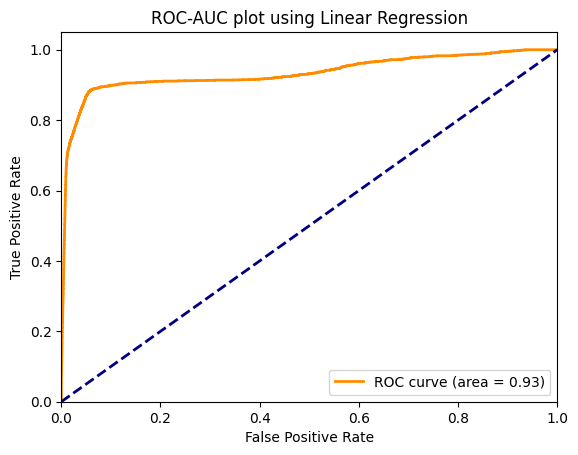

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC plot using Linear Regression')
plt.legend(loc="lower right")
plt.show()

# decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Create a logistic regression model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train_scaled, y_train)

# Predictions
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities needed for AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Additional Metrics
auc_score = roc_auc_score(y_test, probabilities)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Confusion Matrix:
[[253658    535]
 [   645   1800]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254193
           1       0.77      0.74      0.75      2445

    accuracy                           1.00    256638
   macro avg       0.88      0.87      0.88    256638
weighted avg       1.00      1.00      1.00    256638

AUC: 0.87
Accuracy: 1.00
F1 Score: 0.75
Precision: 0.77
Recall: 0.74


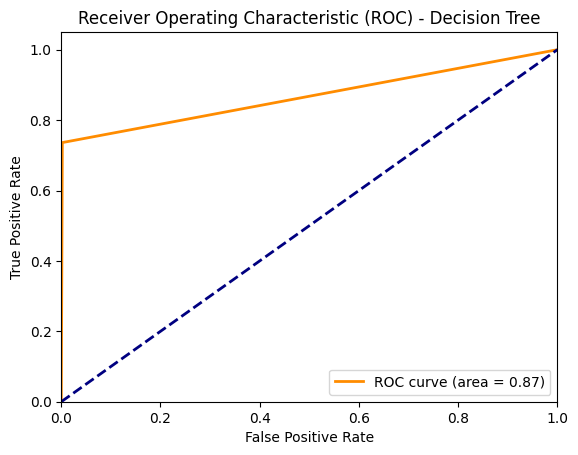

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# xgboost

In [33]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities needed for AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Additional Metrics
auc_score = roc_auc_score(y_test, probabilities)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Confusion Matrix:
[[253838    355]
 [   392   2053]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254193
           1       0.85      0.84      0.85      2445

    accuracy                           1.00    256638
   macro avg       0.93      0.92      0.92    256638
weighted avg       1.00      1.00      1.00    256638

AUC: 1.00
Accuracy: 1.00
F1 Score: 0.85
Precision: 0.85
Recall: 0.84


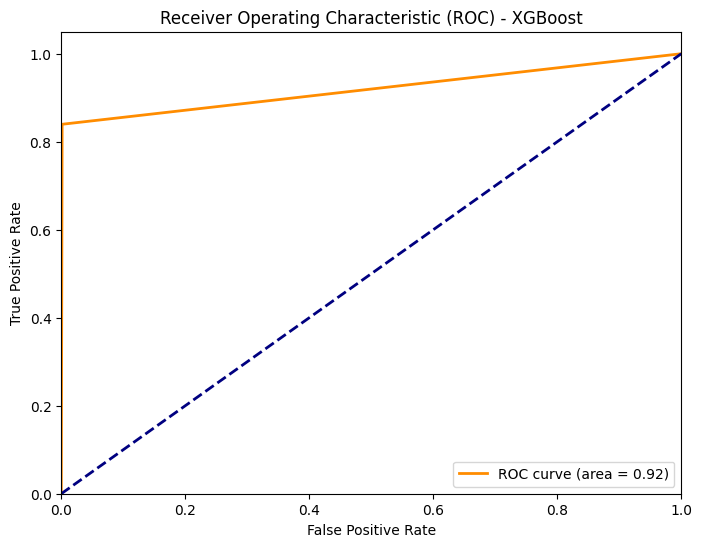

In [35]:
y_pred_probs = model.predict(X_test_scaled)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.show()

# neural network

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

In [31]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
results = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss, Test Accuracy, Test Precision, Test Recall, Test AUC: {results}")


/Users/long/miniforge3/envs/langchain/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14971/14971 ━━━━━━━━━━━━━━━━━━━━ 12s 753us/step - accuracy: 0.9875 - auc: 0.8775 - loss: 0.0485 - precision: 0.4069 - recall: 0.2361 - val_accuracy: 0.9958 - val_auc: 0.9335 - val_loss: 0.0176 - val_precision: 0.7942 - val_recall: 0.7518
Epoch 2/50
14971/14971 ━━━━━━━━━━━━━━━━━━━━ 10s 673us/step - accuracy: 0.9952 - auc: 0.9418 - loss: 0.0193 - precision: 0.7717 - recall: 0.6739 - val_accuracy: 0.9960 - val_auc: 0.9583 - val_loss: 0.0146 - val_precision: 0.7749 - val_recall: 0.8025
Epoch 3/50
14971/14971 ━━━━━━━━━━━━━━━━━━━━ 11s 747us/step - accuracy: 0.9954 - auc: 0.9608 - loss: 0.0166 - precision: 0.7793 - recall: 0.6920 - val_accuracy: 0.9962 - val_auc: 0.9665 - val_loss: 0.0135 - val_precision: 0.8051 - val_recall: 0.7865
Epoch 4/50
14971/14971 ━━━━━━━━━━━━━━━━━━━━ 14s 901us/step - accuracy: 0.9953 - auc: 0.9682 - loss: 0.0159 - precision: 0.7734 - recall: 0.6885 - val_accuracy: 0.9961 - val_auc: 0.9816 - val_loss: 0.0130 - val_precision: 0.8183 - val_recall: 0.7571
Epoc

KeyboardInterrupt: 

8020/8020 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


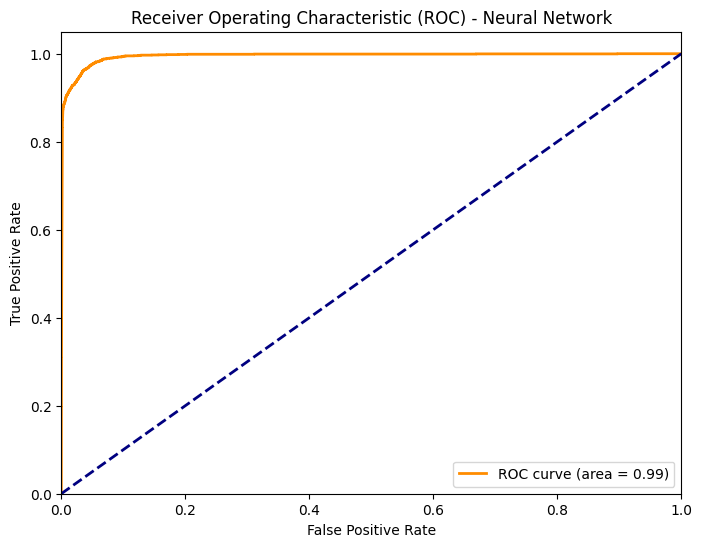

In [32]:
y_pred_probs = model.predict(X_test_scaled)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Neural Network')
plt.legend(loc="lower right")
plt.show()